In [28]:
import netCDF4 as nc
import os
import pandas as pd
from statsmodels.tsa.seasonal import STL
from scipy import signal
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, kstest
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
import warnings
warnings.filterwarnings('ignore')

## Читаем файл с точками

In [41]:
points_ds=pd.read_csv('./test_grid(20x4).csv', sep=',')
points_ds

,id,x,y
0,1,8.72,76.04
1,11,10.72,76.84
2,15,10.72,76.04
3,19,10.72,75.24
4,35,12.72,76.84
5,39,12.72,76.04
6,43,12.72,75.24
7,60,14.72,76.04
8,64,14.72,75.24
9,79,16.72,76.04


In [42]:
def idx_by_2coord(coordinate, lat_array, lon_array):
    # делаем один двумерный массив, в котором каждая ячейка содержит и широту и долготу
    coord_array=np.concatenate((np.array([np.ravel(lat_array)]).T, np.array([np.ravel(lon_array)]).T), axis=1)
    # переворачиваем его к исходной форме
    coord_array=np.reshape(coord_array, (lat_array.shape[0],lat_array.shape[1], 2))
    # вычитаем из каждой координаты нашу координату
    dif=np.abs(coord_array-coordinate)
    # суммируем модули отклонения по обеим координатам
    dis=np.sum(dif, axis=2)
    
    #plt.imshow(dis) # центр "крестика" и есть наша точка
    
    # извлекаем индекс центра "крестика"
    geo_idx = np.unravel_index(dis.argmin(), dis.shape)
    return geo_idx

## Создаем дататест по сетке с ARCTIC reanalysis

In [43]:
nc_file = './arctic-ssh-y2002.nc'
ds = nc.Dataset(nc_file)

In [44]:
coordinates_from_map={'lat': points_ds['y'].tolist(),
                      'lon': points_ds['x'].tolist()}

names_dict={}

for i in range (len(coordinates_from_map['lat'])):
    name=str(coordinates_from_map['lat'][i])+'_'+str(coordinates_from_map['lon'][i])
    names_dict[name]=[]
#print(names_dict)

for j in range(365):  
    sea_level=np.array(ds['ssh'])[j]
    for i in range (len(coordinates_from_map['lat'])):       
        #print('Day: '+str(j)+'Point: '+str(i))        

        in_lat = coordinates_from_map['lat'][i]
        in_lon = coordinates_from_map['lon'][i]

        lats = ds.variables['latitude'][:]
        lons = ds.variables['longitude'][:]

        idx = idx_by_2coord([in_lat, in_lon], lats, lons)

        value=sea_level[idx[0], idx[1]]
        name=str(coordinates_from_map['lat'][i])+'_'+str(coordinates_from_map['lon'][i])
        names_dict[name].append(value)
#names_dict

In [45]:
pd_df = pd.DataFrame(names_dict, columns = list(names_dict.keys()))
per = pd.date_range(start ='1-1-2002', end ='31-12-2002', freq ='1D')
pd_df['dates']=per
pd_df=pd_df.sort_values(by=['dates'])
pd_df.to_csv('./timelines_data/formed_timelines_2002/2002_ARCTIC_reanalysis_GRID(20x4).csv', sep=';', index=False)
pd_df

,76.04_8.72,76.84_10.72,76.04_10.72,75.24_10.72,76.84_12.72,76.04_12.72,75.24_12.72,76.04_14.72,75.24_14.72,76.04_16.72,...,77.64_26.72,76.84_26.72,76.04_26.72,75.24_26.72,77.64_28.72,76.84_28.72,76.04_28.72,76.84_30.72,76.84_32.72,dates
0,-0.514026,-0.490904,-0.505013,-0.504541,-0.474009,-0.475800,-0.466784,-0.466410,-0.440308,-0.475671,...,-0.463300,-0.483881,-0.488676,-0.482278,-0.476966,-0.487291,-0.484595,-0.466387,-0.467363,2002-01-01
1,-0.489136,-0.462158,-0.474494,-0.476335,-0.441902,-0.440805,-0.433289,-0.426805,-0.402837,-0.436296,...,-0.421049,-0.442016,-0.436966,-0.424856,-0.422261,-0.432046,-0.419160,-0.397489,-0.383589,2002-01-02
2,-0.479917,-0.452205,-0.462708,-0.465629,-0.433796,-0.428640,-0.422872,-0.421626,-0.396235,-0.444160,...,-0.422006,-0.457604,-0.468653,-0.493047,-0.435244,-0.450208,-0.464886,-0.414249,-0.416425,2002-01-03
3,-0.464741,-0.437363,-0.445488,-0.450081,-0.423206,-0.413174,-0.407684,-0.410915,-0.382643,-0.443605,...,-0.432630,-0.452329,-0.465651,-0.452099,-0.445046,-0.460764,-0.458153,-0.454798,-0.455870,2002-01-04
4,-0.471832,-0.446991,-0.457838,-0.464278,-0.441023,-0.430873,-0.425995,-0.431374,-0.403699,-0.452025,...,-0.420274,-0.434874,-0.440319,-0.440864,-0.424702,-0.436486,-0.430279,-0.417114,-0.400696,2002-01-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,-0.492056,-0.471487,-0.459913,-0.459917,-0.448348,-0.450405,-0.433060,-0.402826,-0.407588,-0.371947,...,-0.390091,-0.385147,-0.378910,-0.371590,-0.396661,-0.375428,-0.374658,-0.337861,-0.362003,2002-12-27
361,-0.493447,-0.477272,-0.464018,-0.462313,-0.452515,-0.456062,-0.438848,-0.409728,-0.413011,-0.387459,...,-0.402062,-0.393761,-0.400999,-0.387640,-0.409411,-0.391532,-0.391019,-0.368982,-0.384619,2002-12-28
362,-0.488364,-0.474330,-0.459189,-0.454858,-0.449908,-0.451982,-0.432083,-0.408314,-0.405564,-0.398027,...,-0.407073,-0.401779,-0.405479,-0.388208,-0.413683,-0.398627,-0.392783,-0.378845,-0.384335,2002-12-29
363,-0.479422,-0.459351,-0.446626,-0.443176,-0.433942,-0.438416,-0.417221,-0.393139,-0.391157,-0.385504,...,-0.396561,-0.387477,-0.393746,-0.376312,-0.402893,-0.386860,-0.380850,-0.365876,-0.368278,2002-12-30


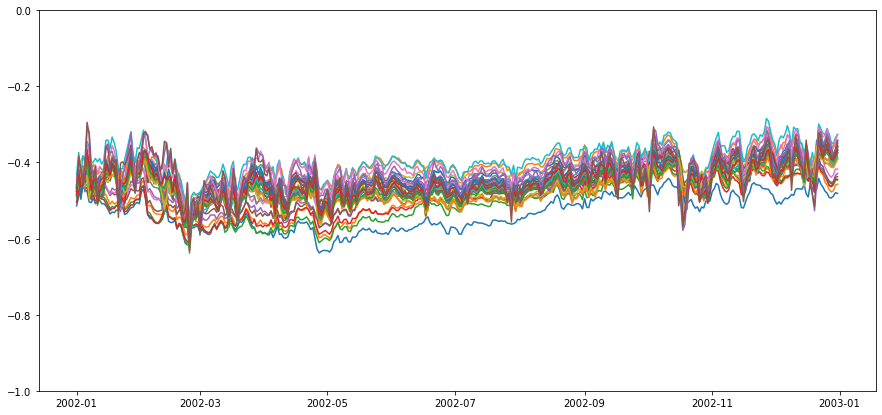

In [46]:
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 15, 7

for key in list(names_dict.keys()):
    if key!='dates':
        plt.plot(pd_df['dates'], pd_df[key], label=key)
plt.ylim(-1, 0)
#plt.legend()
plt.show()

# Пропусков нет - круть

## Создаем дататест по сетке с NEMO_SPITZ

In [47]:
nemo_data_folder='./dataset_SPITZ12'

In [48]:
coordinates_from_map={'lat': points_ds['y'].tolist(),
                      'lon': points_ds['x'].tolist()}

names_dict={}

for i in range (len(coordinates_from_map['lat'])):
    name=str(coordinates_from_map['lat'][i])+'_'+str(coordinates_from_map['lon'][i])
    names_dict[name]=[]
    
for file in os.listdir(nemo_data_folder):
    #print(file)        
    try:
        ds = nc.Dataset(os.path.join(nemo_data_folder, file))
    except Exception as e:
        print(e)
        pass
            
    for i in range (len(coordinates_from_map['lat'])):        
        
        sea_level=np.array(ds['zos'][:, :, :])[0]

        in_lat = coordinates_from_map['lat'][i]
        in_lon = coordinates_from_map['lon'][i]

        lats = np.array(ds['nav_lat'])
        lons = np.array(ds['nav_lon'])

        idx = idx_by_2coord([in_lat, in_lon], lats, lons)

        value=sea_level[idx[0], idx[1]]
        name=str(coordinates_from_map['lat'][i])+'_'+str(coordinates_from_map['lon'][i])
        names_dict[name].append(value)

[Errno -51] NetCDF: Unknown file format: b'./dataset_SPITZ12\\SPITZ_1d_00010101_00011231_grid_T_00010101-00010101.nc.aux.xml'


In [49]:
pd_df = pd.DataFrame(names_dict, columns = list(names_dict.keys()))
per = pd.date_range(start ='1-1-2002', end ='1-1-2003', freq ='1D')
pd_df['dates']=per
pd_df=pd_df.sort_values(by=['dates'])
pd_df.to_csv('./timelines_data/formed_timelines_2002/2002_NEMO_SPITZ_GRID(20x4).csv', sep=';', index=False)
pd_df

,76.04_8.72,76.84_10.72,76.04_10.72,75.24_10.72,76.84_12.72,76.04_12.72,75.24_12.72,76.04_14.72,75.24_14.72,76.04_16.72,...,77.64_26.72,76.84_26.72,76.04_26.72,75.24_26.72,77.64_28.72,76.84_28.72,76.04_28.72,76.84_30.72,76.84_32.72,dates
0,-0.942993,-0.954066,-0.932426,-0.948432,-0.925401,-0.835076,-0.937827,-0.879325,-0.855169,-0.871750,...,-0.872639,-0.879481,-0.901866,-0.893645,-0.886945,-0.908212,-0.908892,-0.865533,-0.857126,2002-01-01
1,-0.942993,-0.954066,-0.932426,-0.948432,-0.925401,-0.835076,-0.937827,-0.879325,-0.855169,-0.871750,...,-0.872639,-0.879481,-0.901866,-0.893645,-0.886945,-0.908212,-0.908892,-0.865533,-0.857126,2002-01-02
2,-0.954143,-0.978555,-0.938155,-0.968829,-0.918114,-0.839382,-0.965822,-0.912459,-0.869913,-0.904009,...,-0.891230,-0.909200,-0.919206,-0.910056,-0.894616,-0.921222,-0.924535,-0.876808,-0.881724,2002-01-03
3,-0.931632,-0.947025,-0.913621,-0.952112,-0.889815,-0.830098,-0.942599,-0.882520,-0.844514,-0.884683,...,-0.889541,-0.907832,-0.933303,-0.921725,-0.889525,-0.928406,-0.933121,-0.896532,-0.893768,2002-01-04
4,-0.916045,-0.932223,-0.891008,-0.933533,-0.875065,-0.815077,-0.916859,-0.863985,-0.833975,-0.883611,...,-0.877725,-0.889649,-0.895313,-0.897191,-0.877825,-0.906409,-0.904075,-0.882398,-0.869840,2002-01-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361,-0.926950,-0.933425,-0.927764,-0.881063,-0.867385,-0.856952,-0.927863,-0.797035,-0.819045,-0.820388,...,-0.809683,-0.799674,-0.812022,-0.818704,-0.812556,-0.805665,-0.804164,-0.778285,-0.795469,2002-12-28
362,-0.938924,-0.948281,-0.933945,-0.893736,-0.863451,-0.853295,-0.940569,-0.803930,-0.836502,-0.834090,...,-0.809915,-0.801875,-0.813401,-0.821298,-0.814592,-0.805104,-0.807658,-0.782651,-0.799299,2002-12-29
363,-0.949362,-0.964308,-0.938396,-0.904764,-0.864230,-0.871458,-0.950721,-0.808116,-0.844918,-0.849075,...,-0.804568,-0.798142,-0.807591,-0.821118,-0.809655,-0.799155,-0.800991,-0.781056,-0.793030,2002-12-30
364,-0.957105,-0.975956,-0.942421,-0.914997,-0.870716,-0.904558,-0.956885,-0.812537,-0.850126,-0.856149,...,-0.798812,-0.794392,-0.815651,-0.827566,-0.804054,-0.795000,-0.805788,-0.779540,-0.788577,2002-12-31


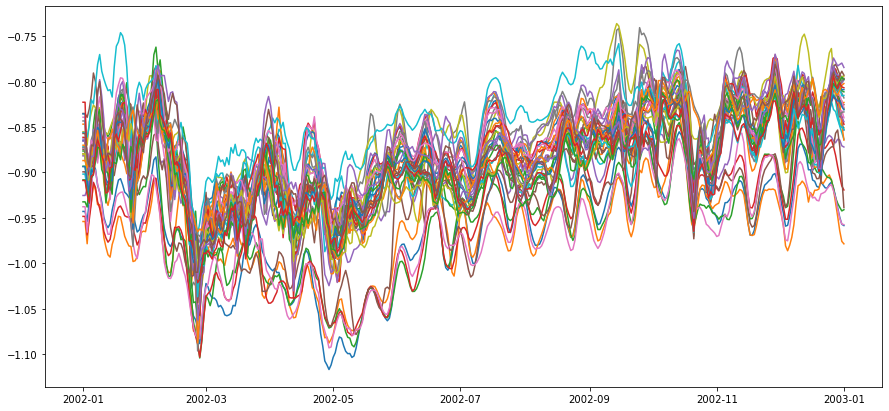

In [50]:
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 15, 7

for key in list(names_dict.keys()):
    if key!='dates':
        plt.plot(pd_df['dates'], pd_df[key], label=key)

#plt.legend()
plt.show()